In [1]:
## good for development
%load_ext autoreload
%autoreload 2

The objective of this notebook is to provide a first glimpse at the simulation and prepare the dataset for the foreground-removal exercise. After having loaded the simulation, we add white instrumental noise for each channel. We smooth all maps with a frequency-dependent Gaussian beam. We re-smoothed back to the larger beam so all maps share a common resolution.

In [2]:
# importing the required packages
import numpy as np
import h5py
import healpy as hp
import matplotlib.pyplot as plt

import gmca4im_lib2 as g4i

nu0 = 1420.4 #MHz, the 21cm emitted frequency

### Download the main simulation from https://doi.org/10.5281/zenodo.3991818

---
It includes:
1. Cosmological signal
2. Galactic synchrotron
3. Galactic free-free
4. Extragalactic point sources and background
5. Polarization leakage

The cosmological signal and polarization leakage have been simulated with CRIME [(Alonso et al. 2014)](https://doi.org/10.1093/mnras/stu1666), the galactic foregrounds are generated from the [Planck Sky Model](http://pla.esac.esa.int/pla/), the point sources using the [Battye et al. (2013)](https://doi.org/10.1093/mnras/stt1082) model.

Details are in the [reference paper](https://arxiv.org/abs/2006.05996). 

In [3]:
# we load the downloaded simulation file
file = h5py.File('../sim_PL05_from191030.hd5','r')

In [4]:
# let's have a look at what it contains
file.keys()

<KeysViewHDF5 ['cosmological_signal', 'frequencies', 'gal_ff', 'gal_synch', 'point_sources', 'pol_leakage']>

In [6]:
# let's define a list with the components of the simulation
components = list(file.keys()); components.remove('frequencies')

Let's have a look at the frequencies/channels we work with: 

In [7]:
nu_ch = np.array(file['frequencies'])

print(f'working with {len(nu_ch)} channels, from {min(nu_ch)} to {max(nu_ch)} MHz')
print(f'i.e. channels are {nu_ch[1]-nu_ch[0]} MHz thick')
print(f'corresponding to the redshift range z: [{min(nu0/nu_ch -1.0):.2f} - {max(nu0/nu_ch -1.0):.2f}] ')

working with 400 channels, from 900.5 to 1299.5 MHz
i.e. channels are 1.0 MHz thick
corresponding to the redshift range z: [0.09 - 0.58] 


### Having a look at the components and their spectra

#### Mollweide projections

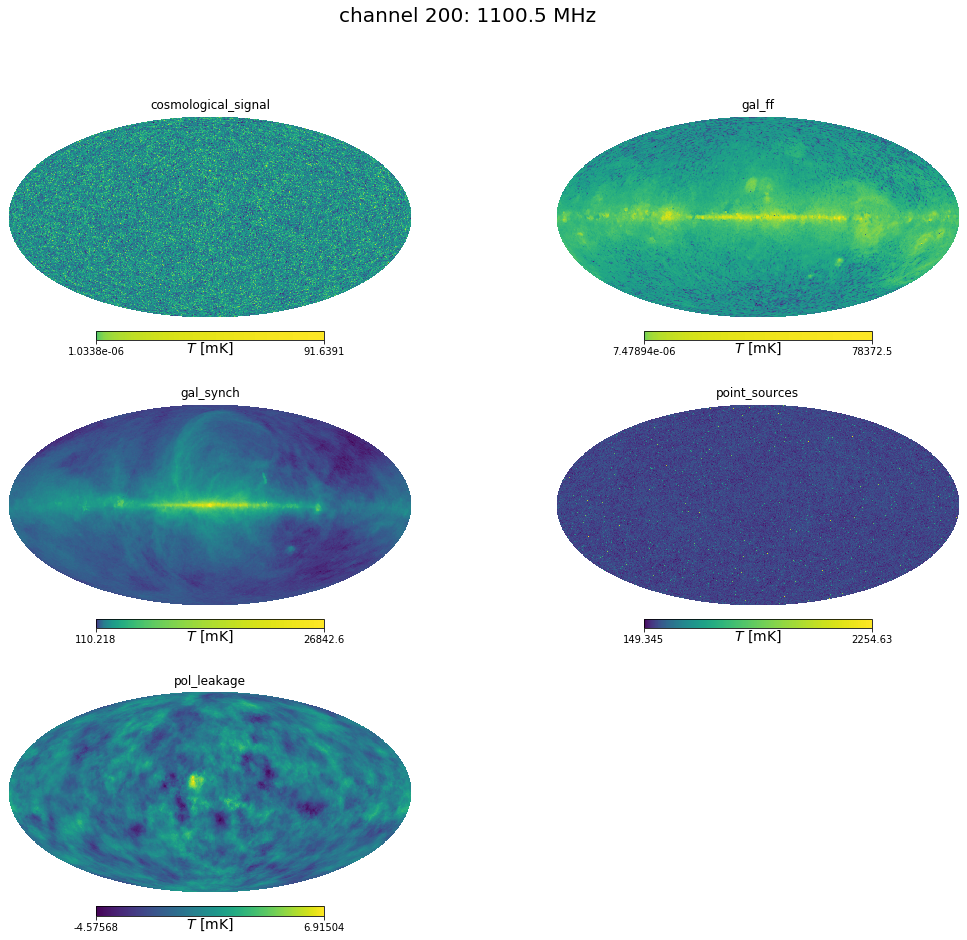

In [12]:
# pick a channel number to image
ich = 200

fig = plt.figure(figsize=(18, 15))
fig.suptitle(f'channel {ich}: {nu_ch[ich]} MHz',fontsize=20)
 
i=1
for c in components:
    ax = fig.add_subplot(3,2,i)
    N = 'log'
    if c=='pol_leakage': N = 'linear'
    hp.mollview(file[c][ich],title=c,unit=r'$T$ [mK]',norm=N,hold=True);
    i+=1


#### Angular power spectra

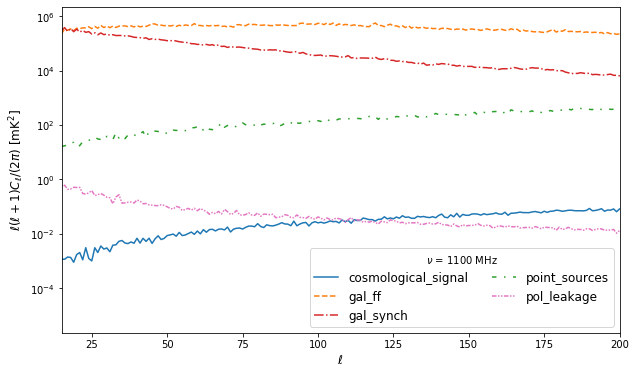

In [20]:
# pick a channel number
ich = 200

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

ls_dic = {'cosmological_signal':"-",'gal_ff':"--",'gal_synch':"-.",'point_sources':(0, (3, 5, 1, 5)),'pol_leakage':(0, (3, 1, 1, 1, 1, 1))}
c_dic = {'cosmological_signal':"#1f77b4",'gal_ff':"#ff7f0e",'gal_synch':"#d62728",'point_sources':"#2ca02c",'pol_leakage':"#e377c2" }


for c in components:
    ell, y = g4i.plot_cl(file[c][ich])
    plt.semilogy(ell, y, ls=ls_dic[c], c=c_dic[c], label=c);


plt.legend(title='$\\nu$ = '+'%4.f'%nu_ch[ich]+' MHz',fontsize=12,ncol=2)
ax = plt.gca()
# ax.set(,ylim=[0.0,0.02],xlabel="$\\ell$",ylabel="$\\ell(\\ell+1)C_{\\ell}/(2\\pi)$ [mK$^2$]");
ax.set(xlim=[15,200],xlabel="$\\ell$",ylabel="$\\ell(\\ell+1)C_{\\ell}/(2\\pi)$ [mK$^2$]");



#### Radial power spectra

sanity check: 
   True   True
   True
using 786432 LoS
each divided into 400 cells of 1.0 MHz
removing mean from maps . .
defining DeltaT array . .

FFT the overdensity temperature field along LoS
done!

sanity check: 
   True   True
   True
using 786432 LoS
each divided into 400 cells of 1.0 MHz
removing mean from maps . .
defining DeltaT array . .

FFT the overdensity temperature field along LoS
done!

sanity check: 
   True   True
   True
using 786432 LoS
each divided into 400 cells of 1.0 MHz
removing mean from maps . .
defining DeltaT array . .

FFT the overdensity temperature field along LoS
done!

sanity check: 
   True   True
   True
using 786432 LoS
each divided into 400 cells of 1.0 MHz
removing mean from maps . .
defining DeltaT array . .

FFT the overdensity temperature field along LoS
done!

sanity check: 
   True   True
   True
using 786432 LoS
each divided into 400 cells of 1.0 MHz
removing mean from maps . .
defining DeltaT array . .

FFT the overdensity temperature fie

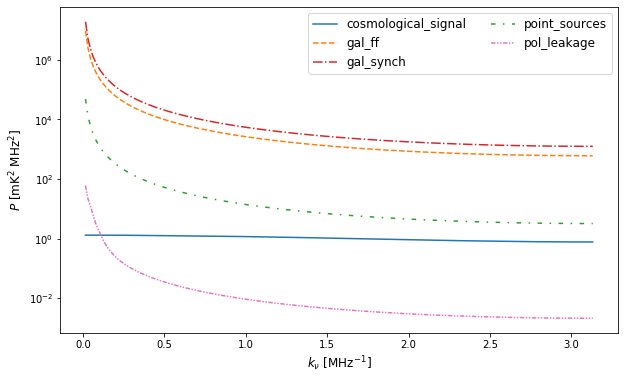

In [21]:
# we are working full-sky, so we pick all available lines-of-sight
indexes_los = np.arange(hp.nside2npix(hp.get_nside(file['gal_ff'][0])))

for c in components:
    k, P = g4i.plot_nuPk(file[c],indexes_los,nu_ch)
    plt.semilogy(k, P, ls=ls_dic[c], c=c_dic[c], label=c);


plt.legend(fontsize=12,ncol=2)
ax = plt.gca()
# ax.set(,ylim=[0.0,0.02],xlabel="$\\ell$",ylabel="$\\ell(\\ell+1)C_{\\ell}/(2\\pi)$ [mK$^2$]");
ax.set(xlabel="$k_{\\nu}$ [MHz$^{-1}$]",ylabel="$P$ [mK$^2$ MHz$^2$]");

# ax.set(xlim=[0.06,k.max()],ylim=[0.0,1],xlabel="$k_{\\nu}$ [MHz$^{-1}$]",ylabel="$P$ [mK$^2$ MHz$^2$]");



### Merging channels
To speed up this demonstration:

1. we don't include polarization leakage in final data-cube (as the blind source separation needs a much higher number of sources to be computed when dealing with polarization leakage),
1. we reduce the number of maps by merging maps in thicker channels.

In [22]:
components.remove('pol_leakage'); print(components)

['cosmological_signal', 'gal_ff', 'gal_synch', 'point_sources']


In [23]:
dnu_out = 10 # MHz
nu_ch_new = g4i.nu_ch_f(nu_ch,dnu_out)

print(f'Merging maps, going from {len(nu_ch)} to {len(nu_ch_new)} channels')
print(f'  i.e. from dnu={nu_ch[1]-nu_ch[0]} MHz to {dnu_out} MHz\n')

sim_dic = {}

for c in components:
    tmp = g4i.merging_maps(nu_ch,nu_ch_new,file[c],dnu_out)
    sim_dic.update({c: tmp}); del tmp
    
nu_ch = nu_ch_new; del nu_ch_new
file.close()

Merging maps, going from 400 to 40 channels
  i.e. from dnu=1.0 MHz to 10 MHz



### Making noise realisation
We choose survey parameters MeerKLASS-like:

In [24]:
## initialise a dictionary with the instrument specifications
## for noise and beam calculation

dish_diam = 13.5  # m
T_inst    = 20.0  # K
f_sky     = 0.1   # Survey area (sky fraction)
t_obs     = 4000. # hrs, observing time
Ndishes   = 64.   # number of dishes

specs_dict = {'dish_diam': dish_diam, 'T_inst': T_inst,
              'f_sky': f_sky, 't_obs': t_obs, 'Ndishes' : Ndishes}


Instrumental noise is white noise with a frequency-dependent variance per pixel defined in equation (10) in the [reference paper](https://arxiv.org/abs/2006.05996).

In [25]:
dnu = nu_ch[1]-nu_ch[0]
nside_out = int(np.sqrt(np.shape(sim_dic['cosmological_signal'])[1] / 12))

sigma_noise = g4i.sigma_N(nu_ch,dnu,**specs_dict)

noise = [g4i.noise_map(sigma,nside=nside_out) for sigma in sigma_noise]
del sigma_noise

### Telescope beam

We convolve the maps with a Gaussian beam with frequency-dependent width as in equation (9) in the [reference paper](https://arxiv.org/abs/2006.05996). 

In [ ]:
print('Computing beam size using given survey specifics:')

max_theta  = g4i.theta_FWHM(np.min(nu_ch),specs_dict['dish_diam']) 
min_theta  = g4i.theta_FWHM(np.max(nu_ch),specs_dict['dish_diam'])

print('\n%.3f < theta_beam [deg] < %.3f \n'%(min_theta*180/np.pi,max_theta*180/np.pi))

LMAX = 3*nside_out

theta_ar  = g4i.theta_FWHM(nu_ch,specs_dict['dish_diam'])
Beam_l_nu = [g4i.getBeam(theta_ar[i],LMAX) for i in range(len(nu_ch))]

for c in components:
    print(f'  convolving the {c} maps . . ')
    # convolve with a frequency-dependent beam
    tmp_out = [g4i.convolve(sim_dic[c][i],Beam_l_nu[i],LMAX) for i in range(len(nu_ch))]
    sim_dic.update({c: tmp_out}); del tmp_out

del Beam_l_nu

Computing beam size using given survey specifics:

0.983 < theta_beam [deg] < 1.407 

  convolving the cosmological_signal maps . . 


Before performing the blind source separation, we make all maps share the same resolution,
i.e. we downgrade maps to worst beam (lower frequency):

In [ ]:
print('Smoothing again to same resolution . .')
beam_to_worst = [g4i.getBeam(np.sqrt(max_theta**2-theta_ar[i]**2),LMAX) for i in range(len(nu_ch))]

for c in components:
    # smooth again to a same resolution
    print(f'  de-convolving the {c} maps . . ')
    tmp_out = [g4i.convolve(sim_dic[c][i],beam_to_worst[i],LMAX) for i in range(len(nu_ch))]
    sim_dic.update({c: tmp_out}); del tmp_out

print('  also the noise maps gets smoothed . .')
# doing same thing on the noise maps
noise_tmp = [g4i.convolve(noise[i],beam_to_worst[i],LMAX) for i in range(len(nu_ch))]
del noise; noise = noise_tmp; del noise_tmp


Let's save these observed maps into a file (that we will load and use in the next notebook).

In [ ]:
sim_dic.update({'noise': noise})

file_out = h5py.File(f'../sim_{int(dnu)}MHz.hd5','w')
for c in components:
    file_out.create_dataset(c, data=sim_dic[c])
    
file_out.create_dataset('noise', data=noise)
file_out.create_dataset('frequencies', data=nu_ch)

file_out.close()